/Users/paytone/Documents/GitHub/Mart2Aust_Hackathon/orix/crystal_map/utilities.py:543: UserWarning: parameter a must be of integer type. Converting a into integers and moving on...
  warnings.warn('parameter ''a'' must be of integer type. Converting ''a'' into integers and moving on...')
/Users/paytone/anaconda3/envs/hackathon/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


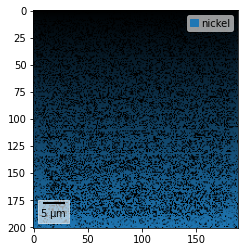

In [2]:
import numpy as np
import orix
import matplotlib.pyplot as plt
from diffpy.structure import Atom, Lattice, Structure

from orix import plot
from orix.crystal_map import CrystalMap, Phase, PhaseList
from orix.io import load, save
from orix.quaternion import Orientation, Rotation, symmetry
from orix.vector import Vector3d
import orix.crystal_map.utilities as outil

from scipy.sparse import csr_matrix, coo_matrix, find, triu
from scipy.sparse.csgraph import connected_components

%matplotlib inline

dataPath = '/Users/paytone/Desktop/'
#fileName = 'twins.ctf'
fileName = 'Slice_1.ang'
target = dataPath + fileName

# ANG load:
euler1, euler2, euler3, x, y, iq, ci, phase_id, sem, fit = np.loadtxt(target, unpack=True)
properties = dict(iq=iq, dp=ci)

# Create unit cells of the phases
structures = [
    Structure(
        title="nickel",
        atoms=[Atom("ni", [0] * 3)],
        lattice=Lattice(3.520, 3.520, 3.520, 90, 90, 90)
    ),
]
phase_list = PhaseList(
    names=["nickel"],
    point_groups=["m-3m"],
    structures=structures,
)

# CTF load:
#phase_id, x, y, bands, error, euler1, euler2, euler3, mad, bc, bs = np.loadtxt(target, unpack=True, skiprows=15)
#properties = dict(iq=bc, dp=bs)




#structures = [Structure(title="magnesium", atoms=[Atom("mg", [0] *3)], 
#                        lattice=Lattice(3.2089,3.2089,5.2101,90,90,120)),]

#phase_list = PhaseList(names=["magnesium"], point_groups=["6/mmm"], structures=structures,)

euler_angles = np.column_stack((euler1, euler2, euler3))
rotations = Rotation.from_euler(euler_angles*np.pi/180.)

# Create a CrystalMap instance
xmap2 = CrystalMap(
    rotations=rotations,
    phase_id=phase_id,
    x=x,
    y=y,
    phase_list=phase_list,
    prop=properties,
)
xmap2.scan_unit = "um"

xmap2 = outil.calc_grains(xmap2)


xmap2.plot(overlay='grain_id')

In [ ]:
phase_id

In [7]:
np.shape(np.unique(xmap2.prop['grain_id']))

(24717,)

In [6]:
xmap2.shape[0] * xmap2.shape[1]

37989

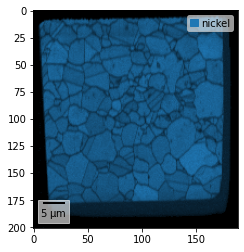

In [3]:
xmap2.plot(overlay='iq')

In [ ]:
from orix.crystal_map.utilities import spatial_decomposition

In [ ]:
def gbc_angle(q1, s1, Dl, Dr, threshold):
    '''
    implements misorientation angle based grain boundary threshold for grain segmentation
    
    Parameters
    ----------
    q1 : quaternion class for rotations
    s1 : symmetry class
    Dl : indices of q1 for adjacent 
    Dr : indices of q1 for 
    threshold : angular threshold value in radians
    
    Returns
    -------
    criterion : bool
    '''
    # still needs **kwargs to enable two misorientation angle choices like MTEX
     
    qs = Orientation(q1,s1)
    qs = qs.map_into_symmetry_reduced_zone()
    
    
    o1 = qs[Dl]
    o2 = qs[Dr]
    
    # Original matlab: mis = angle(orientation(q(Dl),CS),orientation(q(Dr),CS))
    mis = o1-o2
    #mis = mis.map_into_symmetry_reduced_zone() #TODO: When a misorientation class is created, it should be used here
    
    
    # if np.ndarray.size(threshold) == 1:
    criterion = mis.angle > cos(threshold/2.)
    
    return criterion, mis

def do_segmentation(I_FD, ebsd, gbc_value=5., maxDist=0):
    """
    Parameters
    ----------
    I_FD : scipy sparse matrix faces to vertices
    
    Returns
    --------
    A_Db : scipy sparse matrix
        adjacency matrix of grain boundaries
        
    A_Do : scipy sparse matrix
        adjacency matrix inside grain connections
    
    """

    # Output
    # A_Db - adjacency matrix of grain boundaries
    # A_Do - adjacency matrix inside grain connections

    # convert gbc value to radians
    threshold = gbc_value * np.pi / 180.0

    ## if numel(gbcValue) == 1 && length(ebsd.CSList) > 1
    phase_ids = np.unique(ebsd.phase_id)
    if np.size(gbc_value) == 1 and len(phase_ids) > 1:
        ##   gbcValue = repmat(gbcValue,size(ebsd.CSList))
        threshold = np.repeat(threshold, np.shape(phase_ids))
    else:
        threshold = np.atleast_1d(threshold)  

    # get pairs of neighbouring cells {D_l,D_r} in A_D
    A_D = I_FD.T * I_FD == 1

    ## [Dl,Dr] = find(triu(A_D,1))
    Dl, Dr, _  = find(triu(A_D, k=1))          # Get upper triangular part of matrix

    connect = np.zeros(np.shape(Dl), dtype=bool)

    ## for p = 1:numel(ebsd.phaseMap)
    for p in phase_ids:

        ndx = np.all(np.vstack([ebsd.phase_id[Dl] == p, ebsd.phase_id[Dr] == p]), axis=0)

        connect[ndx] = True        

        # check whether they are indexed
        ndx = np.all([ndx, ebsd.is_indexed[Dl], ebsd.is_indexed[Dr]])                            # returns index if all true

        # now check for the grain boundary criterion
        if np.any(ndx):

            connect[ndx], mis = gbc_angle(ebsd.rotations, ebsd.phases.point_groups[p-1], Dl[ndx], Dr[ndx], threshold[ndx])

    # adjacency of pixels that are in different grains
    A_Do = csr_matrix((np.ones(np.shape(Dl[connect])), (Dl[connect], Dr[connect])), shape=(ebsd.size, ebsd.size))
    rows, cols = A_Do.nonzero()
    A_Do[cols, rows] = A_Do[rows, cols] # Make symmetric

    # adjacency of pixels that are in the same grains
    mask = np.ones(connect.shape, dtype=bool)
    mask[connect] = False
    A_Db = coo_matrix((np.ones(np.shape(Dl[mask])), (Dl[mask], Dr[mask])), shape=(ebsd.size, ebsd.size));
    A_Db = A_Db.tocsr()
    rows, cols = A_Db.nonzero()
    A_Db[cols, rows] = A_Db[rows, cols] # Make symmetric

    return A_Db, A_Do, mis

In [ ]:
ebsd = xmap2 # imported by different name above

V, F, I_FD = spatial_decomposition(np.array([ebsd.x, ebsd.y]).T)
# V - list of vertices
# F - list of faces
# D - cell array of cells
# I_FD - incidence matrix faces to vertices

# determine which cells to connect
A_Db, A_Do, mis = do_segmentation(I_FD, ebsd)
# A_Db - neighbouring cells with grain boundary
# A_Do - neighbouring cells without grain boundary

#then cluster like this:
n_clusters, feature_clusters = connected_components(A_Do, directed=False, connection='strong')
#feature_clusters = feature_clusters[1]

# compute grains as connected components of A_Do
## I_DG - incidence matrix cells to grains
# I_DG = coo_matrix((np.ones(len(feature_clusters), dtype=np.int32),
#                  (np.arange(0,len(feature_clusters), dtype=np.int32), feature_clusters)), 
#                  shape=(len(feature_clusters), max(feature_clusters)+1))

# compute grain ids
#grain_id = find(I_DG.T)

#ebsd.prop.grain_id = feature_clusters
ebsd.prop["grain_id"] = feature_clusters

In [ ]:
ebsd.plot(overlay='iq')

In [ ]:
n_clusters

In [ ]:
mis.angle

In [ ]:
np.sum(mis.angle < 5.*np.pi/180.)

In [ ]:
mis.angle.shape

In [ ]:
feature_clusters

In [ ]:
z = np.unique(feature_clusters)

In [ ]:
z.shape

In [5]:
xmap2.shape[0] * xmap2.shape[1]

37989